In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from matplotlib import animation
from scipy import stats

import sys; sys.path.insert(1, '/saturn/simu_Caribbean/coupled_2km')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
import warnings; warnings.filterwarnings("ignore")

In [2]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'

wrf_files = path + 'Caraibes_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [3]:
# open data - HOURLY
ds_hourly = xr.open_dataset(wrf_files)    #mfdataset(fname_list, concat_dim='Time', combine='nested')
'''ds_hourly = ds_tot.sel(time_counter=slice('2006-02-01T00:30:00.000000000', '2006-03-01T00:30:00.000000000'))
del ds_tot'''
# lat and lon
lon_M = ds_hourly['nav_lon'].values
lat_M = ds_hourly['nav_lat'].values

In [ ]:
############# QUI CREO UNA NUOVA MASCHERA RIMUOVENDO LE ISOLETTE DI SST CALDA 
############# CHE NON ERANO RICONOSCIUTE COME LAND
############# SALVATA IN sea_mask_EU_new.npy

In [4]:
#########  MASKING

'''#########  start with rect         y = 0:300   , x = 0:end
######### then with small square   y = 400:end , x = 0:150'''
sst = ds_hourly['SST']
sst_mask = sst[10,:,:]/sst[10,:,:]
sst_mask = sst_mask.where(sst_mask>0, other=0, drop=False)
land_mask =  1-sst_mask

In [45]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_nobnd_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_nobnd_EU.npy')

In [49]:
# rettangolone
santa_lucia = np.argwhere((lon_M[1,:]>=-62.) & (lon_M[1,:]<=-61.)& (lat_M>=11.8) & (lat_M<=13.5))

# cubetto 2
barbados = np.argwhere((lon_M[1,:]>=-59.8) & (lon_M[1,:]<=-59.3)& (lat_M>=12.93) & (lat_M<=13.5))

# rettangolino
scarborough = np.argwhere((lon_M>=-61.) & (lon_M<=-60.4) & (lat_M>=11.) & (lat_M<=11.5))

# aggiunta
add = np.argwhere((lon_M>=-62.) & (lon_M<=-61.8) & (lat_M>=10.2) & (lat_M<=11.2))

In [52]:
sea_mask[santa_lucia[:,0], santa_lucia[:,1]] = 0
sea_mask[scarborough[:,0], scarborough[:,1]] = 0
sea_mask[barbados[:,0], barbados[:,1]] = 0
sea_mask[add[:,0], add[:,1]] = 0

In [54]:
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy'):
    np.save('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy', sea_mask)

Text(0, 0.5, 'lat [$^\\circ$]')

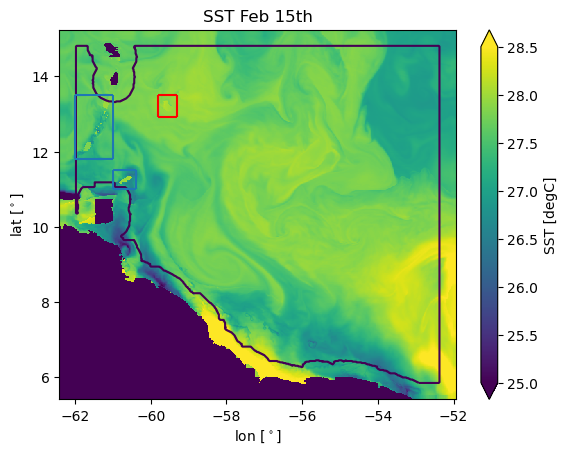

In [42]:
plt.pcolormesh(lon_M, lat_M, sst[15,:,:]-273.15, vmin=25, vmax=28.5, cmap='viridis')
plt.colorbar(extend='both', label='SST [degC]')

plt.contour(lon_M, lat_M, sea_mask, levels=[0.])

# rettangolone - santa lucia
plt.hlines(11.8, xmin=-62, xmax=-61, label='1')
plt.vlines(-61., ymin=11.8, ymax=13.5, label='3')
plt.hlines(13.5, xmin=-62, xmax=-61, label='1')
plt.vlines(-62., ymin=11.8, ymax=13.5, label='3')

# cubetto - scarborough
plt.hlines(11.5, xmin=-61, xmax=-60.4, label='1')
plt.vlines(-60.4, ymin=11., ymax=11.5, label='3')
plt.vlines(-61., ymin=11., ymax=11.5, label='3')
plt.hlines(11., xmin=-61, xmax=-60.4, label='1')

# cubetto 2 - barbados
plt.hlines(12.93, xmin=-59.8, xmax=-59.3, label='1', color='red')
plt.vlines(-59.8, ymin=12.93, ymax=13.5, label='3', color='red')
plt.hlines(13.5, xmin=-59.8, xmax=-59.3, label='1', color='red')
plt.vlines(-59.3, ymin=12.93, ymax=13.5, label='3', color='red')

plt.title(f'SST Feb 15th')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')

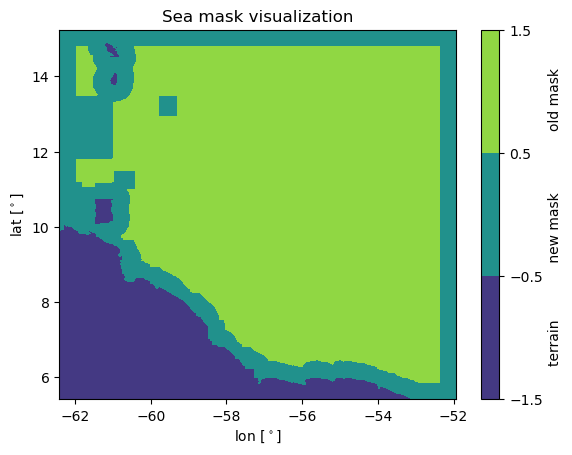

In [53]:
plt.contourf(lon_M, lat_M, -land_mask+sea_mask, levels=[-1.5, -0.5, 0.5, 1.5])
plt.title('Sea mask visualization')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')
cbar = plt.colorbar(label='terrain             new mask              old mask ' )

In [11]:
sst = ds_hourly['SST']
sst_mask = sst[10,:,:]/sst[10,:,:]
sst_mask = sst_mask.where(sst_mask>0, other=0, drop=False)
land_mask =  1-sst_mask

#x = sst_mask.x.values

#sst_coords = np.argwhere(sst_mask[:,0:500].values>0)
#land_coords = np.argwhere(land_mask[:,0:500].values>0)

# width of stripe
width=3
depth = int(573/width)

sst_rshp_vert = np.zeros((546,width,int(depth)))
land_rshp_vert = np.zeros((546,width,int(depth)))

for i in range(depth):
    sst_rshp_vert[:,:,i] = sst_mask[:,i*width:(i+1)*width]
    land_rshp_vert[:,:,i] = land_mask[:,i*width:(i+1)*width]


def stripe_funk(sst_rshp_vert_num, land_rshp_vert_num):
    sst_coo = np.argwhere(sst_rshp_vert_num>0)
    land_coo = np.argwhere(land_rshp_vert_num>0)
    
    dist = np.sum((sst_coo[:, None] - land_coo[None, :]) ** 2, axis=-1)
    close_mask = np.any(dist <= 25**2, axis=-1)
    del dist
    
    sst_rshp_vert_num[sst_coo[close_mask][:, 0], sst_coo[close_mask][:, 1]] = 0
    
    #return stripe


        

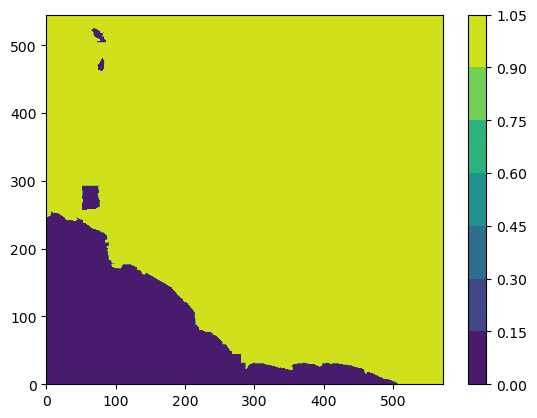

In [6]:
plt.contourf(sst_mask)
plt.colorbar()

In [12]:
for i in range(depth):
    stripe_funk(sst_rshp_vert[:,:,i], land_rshp_vert[:,:,i])


In [14]:
sst_rshp_vert = np.reshape(sst_rshp_vert, (546, 573), order='F')

In [ ]:
'''for i in range(depth-1):
    sst_rshp_vert = np.concatenate((sst_rshp_vert[:,:,i], sst_rshp_vert[:,:,i+1], axis=-1)'''

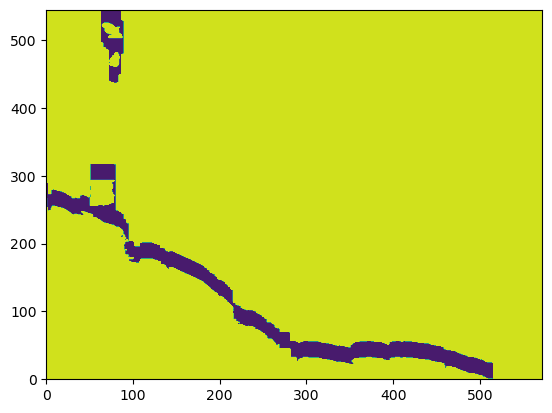

In [40]:
plt.contourf(sst_rshp_vert)

In [86]:
# do the same as before, but horizontal slicing

width = 39
depth = int(546/width)


sst_rshp_hor = np.zeros((depth,width,573))    
land_rshp_hor = np.zeros((depth,width,573))  


for i in range(depth):
    sst_rshp_hor[i,:,:] = sst_mask[i*width:(i+1)*width,:]
    land_rshp_hor[i,:,:] = land_mask[i*width:(i+1)*width,:]

In [87]:
for i in range(depth):   #np.shape(sst_rshp_hor)[-1]
    stripe_funk(sst_rshp_hor[i,:,:], land_rshp_hor[i,:,:])

In [88]:
sst_rshp_hor.shape

(14, 39, 573)

In [89]:
sst_rshp_hor = np.reshape(sst_rshp_hor, (546,573), order='C')

In [81]:
sst_rshp_hor = np.concatenate((sst_rshp_hor[0,:,:], sst_rshp_hor[1,:,:], sst_rshp_hor[2,:,:], sst_rshp_hor[3,:,:], sst_rshp_hor[4,:,:], sst_rshp_hor[5,:,:]), axis=0)   #, sst_mask.values[:,500:]
#sst_rshp_hor = np.concatenate( (sst_rshp_hor, sst_mask.values[:,500:]) , axis=1) 

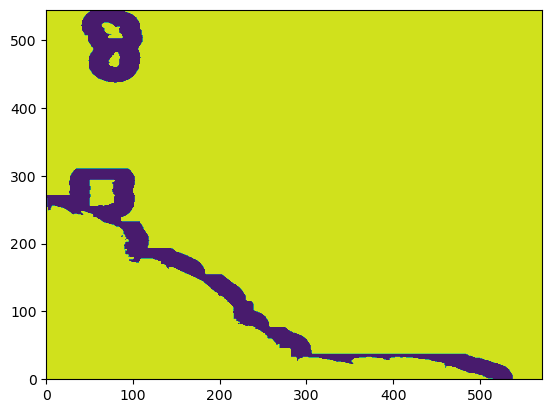

In [90]:
plt.contourf(sst_rshp_hor-sst_mask)

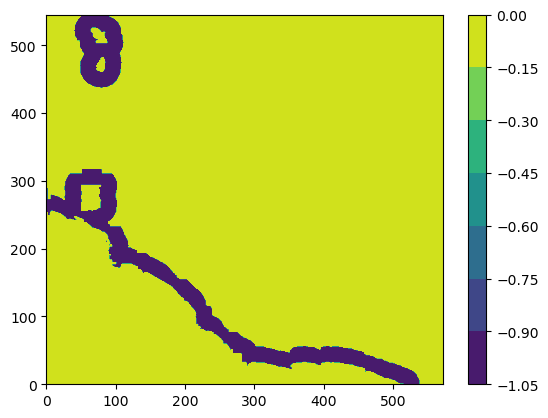

In [91]:
# smooth the two selections
sst_rshp = 0.5*(sst_rshp_hor+sst_rshp_vert)
condition = (sst_rshp == 0.5)
sst_rshp[condition] = 0
plt.contourf(sst_rshp[:,:]-sst_mask[:,:])
plt.colorbar()

In [ ]:
# NOW, SET THE NEW, FINAL MASK
# REMOVE THE TEMPORARY VARS

# sst_rshp is the new sea mask
land_rshp = 1-sst_rshp

del sst_rshp_hor, sst_rshp_vert, land_rshp_vert, land_rshp_vert

In [99]:
# DAMETTERE SU SATURN!

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU.npy'):
    np.save('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU.npy', sst_rshp)
    
'''if os.path.exist('/home/alessandro/tesi/thesis_material/sea_mask.npy'):   #   /home/alessandro/tesi_ale/prove
    np.save('/home/alessandro/thesis_material/EURECA_scripts/sea_mask.npy', sst_rshp)'''

"if os.path.exist('/home/alessandro/tesi/thesis_material/sea_mask.npy'):   #   /home/alessandro/tesi_ale/prove\n    np.save('/home/alessandro/thesis_material/EURECA_scripts/sea_mask.npy', sst_rshp)"

In [ ]:
######### END OF MASKING

In [ ]:
# ANIMATING THINGS

In [100]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU.npy', allow_pickle=True)

lat = ds_hourly.nav_lat
lon = ds_hourly.nav_lon

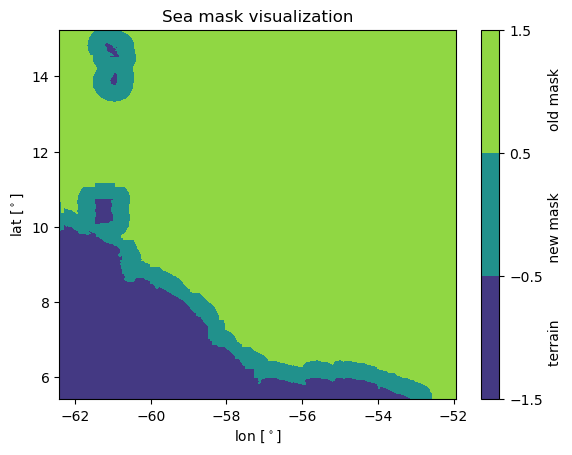

In [101]:
plt.contourf(lon, lat, sea_mask-land_mask, levels=[ -1.5, -0.5, 0.5, 1.5])
plt.title('Sea mask visualization')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')
cbar = plt.colorbar(label='terrain             new mask              old mask ' )

#plt.savefig('/home/alessandro/prove/primi_plot/pbl_mask/viz_mask')

In [ ]:
# saving data to visualize
#pblh = ds_hourly['PBLH'];   pblh = pblh.where(sea_mask, drop=False)
sst = ds_hourly['SST'];     sst = sst.where(sea_mask, drop=False)

In [ ]:
######   T2 AND Q2

In [ ]:
# saving other data
T2 = ds_hourly['T2']; T2 = T2.where(sea_mask, drop=False)
q2 = ds_hourly['Q2']; q2 = q2.where(sea_mask, drop=False)
#Tskin = ds_hourly['TSK']; Tskin = Tskin.where(sea_mask, drop=False)

In [ ]:
# enable interactive plot
%matplotlib notebook

#trange = len(np.unique(ds_hourly['time_counter.day'].values[0:-1]))+1   # the last value is another 1 !
trange = len(T2['time_counter'])
trange = np.arange(trange)
frames = np.arange(0,len(trange),3)

date = ds_hourly['time_counter'].values.astype('<M8[s]')
'''date = ['Feb_' + str(  day  ) for day in sfc_wind_day['day'].values]
#date = 'Feb' + ' ' + sfc_wind_day['day'].values.astype(str)'''   


# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')


# initial plot - T2
Tcont = ax.contour(lon, lat, T2[0,:,:]-273.15, levels=12, cmap='YlOrRd')
ax.clabel(Tcont, inline=True, fontsize=10)

# initial plot - q2
qlevs = np.linspace(np.nanmin(q2),np.nanmax(q2),13)*1000;
qcontf = ax.contourf(lon, lat, 1000*q2[0,:,:], levels=qlevs)
cbar = fig.colorbar(qcontf)
cbar.set_label('qvap 2m [g/kg]')

'''# initial  plot - SFC_WIND
wind_levs = np.linspace(np.nanmin(sfc_wind_day),np.nanmax(sfc_wind_day),15)
contf = ax.contourf(lon, lat, sfc_wind_day[0,:,:], levels=wind_levs) 
cbar = fig.colorbar(contf)
cbar.set_label('wind [m/s]')'''

'''# initial  plot - SELECTED WIND POLES
wind_qui = ax.quiver(lon[lat_plot, lon_plot],lat[lat_plot, lon_plot],  u_plot[0,:,:], v_plot[0,:,:], scale=500)
# colors = arctan2(u, v)
# add this to quiver   color=colormap(norm(colors))'''

'''# initial plot - PRESSURE FIELD
isobars = ax.contour(lon, lat, sfc_pres_day[0,:,:]/100., levels=15, cmap='YlOrRd')
ax.clabel(isobars, inline=True, fontsize=10)'''




# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    qcontf = ax.contourf(lon, lat, 1000*q2[i,:,:], levels=qlevs)
    cbar.update_normal(qcontf)
    
    Tcont = ax.contour(lon, lat, T2[i,:,:]-273.15, levels=12, cmap='YlOrRd')
    ax.clabel(Tcont, inline=True, fontsize=10)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'T contours [$^\circ$C] and qvap [g/kg], date {date[i]}')   
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()


In [ ]:
writer = PillowWriter(fps=2,metadata=dict(artist='Me'),bitrate=1800)
anim.save('/home/alessandro/prove/animazioni/q2_T2.gif', writer=writer)

In [ ]:
######   END  T2 AND Q2

In [ ]:
####### ANIMATING SST-T2

In [ ]:
buoyancy = sst-T2

In [ ]:
# enable interactive plot
%matplotlib notebook

#trange = len(np.unique(ds_hourly['time_counter.day'].values[0:-1]))+1   # the last value is another 1 !
trange = len(T2['time_counter'])
trange = np.arange(trange)
frames = np.arange(0,len(trange),3)

date = ds_hourly['time_counter'].values.astype('<M8[s]')
'''date = ['Feb_' + str(  day  ) for day in sfc_wind_day['day'].values]
#date = 'Feb' + ' ' + sfc_wind_day['day'].values.astype(str)'''   


# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')


# initial plot - SST - T2
# UNDERSTAND 
levs = np.linspace(-9, 9, 17)   #np.linspace(np.nanmin(buoyancy),np.nanmax(buoyancy),13) 
dT_contf = ax.contourf(lon, lat, buoyancy[0,:,:], levels=levs, cmap='bwr', extend="both")
cbar = fig.colorbar(dT_contf)
cbar.set_label('SST-T2 [K]')



# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    dT_contf = ax.contourf(lon, lat, buoyancy[i,:,:], levels=levs, cmap='bwr', extend="both")
    cbar.update_normal(dT_contf)
    
    '''Tcont = ax.contour(lon, lat, T2[i,:,:]-273.15, levels=12, cmap='YlOrRd')
    ax.clabel(Tcont, inline=True, fontsize=10)'''
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'SST-T2 [K], date {date[i]}')   
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()

In [ ]:
##### END OF SST-T2

In [ ]:
######## ANIMATING SST ANOMS AT 200KM

In [ ]:
# compute dsst - HOURLY DATA TAKE TIME TO FILTER
dsst = np.zeros(sst.values.shape)
s = 100
for t in range(0,sst.values.shape[0]):
    if t % 100 == 0:
        print(t)

    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst[t],s)          
    dsst[t] = sst[t] - sst_ave

In [ ]:
# enable interactive plot
%matplotlib notebook

trange = len(ds_hourly['time_counter'].values)
trange = np.arange(trange)
frames = np.arange(0,len(trange),6)

date = ds_hourly['time_counter'].values.astype('<M8[s]')


# setting the levels I need
#levs = np.linspace(0,np.max(pblh),15) 



# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# initial  plot - SST
#Tcont = ax.contour(lon,lat,sst[0,:,:]-273.15, levels=10, cmap='jet')
#ax.clabel(Tcont, inline=True, fontsize=10)

# initial  plot - dSST
norm = colors.TwoSlopeNorm(vmin=np.nanmin(dsst), vcenter=0., vmax=np.nanmax(dsst))

dsst_levs_min= np.linspace(np.nanmin(dsst),0,13);  dsst_levs_max=np.linspace(0,np.nanmax(dsst), 9)
dsst_levs = np.concatenate( (dsst_levs_min, dsst_levs_max))
dsst_levs = np.unique(dsst_levs)

#adj_levs = dsst_levs - 0.5*(np.nanmin(dsst)+np.nanmax(dsst)) 
contf = ax.contourf(lon, lat, dsst[0,:,:],  cmap='bwr', levels=dsst_levs, norm=norm)   #levels=adj_levs)   #pcolormesh

cbar = fig.colorbar(contf)
cbar.set_label('SST anoms [degC]')
cbar.set_ticks(dsst_levs)
cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))


# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    contf = ax.contourf(lon, lat, dsst[i,:,:], cmap='bwr', levels=dsst_levs, norm=norm)  #  #, levels=levs)
    cbar.update_normal(contf)
    cbar.set_ticks(dsst_levs)
    cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'High-passed SST 200km, date {date[i]}')   
    

anima_dsst = animation.FuncAnimation(fig, animate, interval=100, frames=frames, repeat=False)

plt.show()


In [ ]:
writer = PillowWriter(fps=2,metadata=dict(artist='Me'),bitrate=1800)
anima_dsst.save('/home/alessandro/prove/animazioni/dsst_200km.gif', writer=writer)

In [ ]:
######   END OF DSST ANIMATION

In [ ]:
####### ANIMATING WIND WITH DAILY PRESSURE

In [ ]:
#LH = ds_hourly['LH']; LH = LH.where(sea_mask, drop=False)
u, v = ds_hourly['U_PHYL1'], ds_hourly['V_PHYL1']; u, v = u.where(sea_mask, drop=False), v.where(sea_mask, drop=False)
sfc_wind = (u**2+v**2)**(0.5)

In [ ]:
# saving data from daily 

# pressure
pres_day = ds_daily['P']+ds_daily['PB']#; sfc_pres 
pres_day = pres_day.where(sea_mask, drop=False)
sfc_pres_day = pres_day[:,0,:,:]

# compute daily means of hourly wind
u_day, v_day = u.groupby('time_counter.day').mean(), v.groupby('time_counter.day').mean()
sfc_wind_day = sfc_wind.groupby('time_counter.day').mean()

In [ ]:
# plotting wind only every 25x23 (lon lat) gridpoints
lat_plot = np.arange(23,u.shape[1],23)
lon_plot = np.arange(0,u.shape[2]-25,25)
u_plot, v_plot = u_day[:,lat_plot, lon_plot], v_day[:,lat_plot, lon_plot]

In [ ]:
# enable interactive plot
%matplotlib notebook

#trange = len(np.unique(ds_hourly['time_counter.day'].values[0:-1]))+1   # the last value is another 1 !
trange = len(sfc_wind_day['day'])
trange = np.arange(trange)
frames = np.arange(0,len(trange))

date = ['Feb_' + str(  day  ) for day in sfc_wind_day['day'].values]
#date = 'Feb' + ' ' + sfc_wind_day['day'].values.astype(str)   ##ds_hourly['time_counter.day'].values.astype('<M8[s]')


# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# initial  plot - SFC_WIND
wind_levs = np.linspace(np.nanmin(sfc_wind_day),np.nanmax(sfc_wind_day),15)
contf = ax.contourf(lon, lat, sfc_wind_day[0,:,:], levels=wind_levs) 
cbar = fig.colorbar(contf)
cbar.set_label('wind [m/s]')

# initial  plot - SELECTED WIND POLES
wind_qui = ax.quiver(lon[lat_plot, lon_plot],lat[lat_plot, lon_plot],  u_plot[0,:,:], v_plot[0,:,:], scale=500)
# colors = arctan2(u, v)
# add this to quiver   color=colormap(norm(colors))

# initial plot - PRESSURE FIELD
isobars = ax.contour(lon, lat, sfc_pres_day[0,:,:]/100., levels=15, cmap='YlOrRd')
ax.clabel(isobars, inline=True, fontsize=10)




# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    contf = ax.contourf(lon, lat, sfc_wind_day[i,:,:], levels=wind_levs)
    cbar.update_normal(contf)
    
    wind_qui = ax.quiver(lon[lat_plot, lon_plot],lat[lat_plot, lon_plot],  u_plot[i,:,:], v_plot[i,:,:], scale=500)
    
    isobars = ax.contour(lon, lat, sfc_pres_day[i,:,:]/100., levels=15, cmap='YlOrRd')
    ax.clabel(isobars, inline=True, fontsize=10)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'Press [hPa], wind magn and dir, date {date[i]}')   
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()


In [ ]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anim.save('/home/alessandro/prove/animazioni/press_wind_int_dir.gif', writer=writer)

In [ ]:
####### END OF DAILY WIND WITH PRESSURE

In [ ]:
######## TRY TO ANIMATE q*div(U)

In [ ]:
qvap = ds_daily['QVAPOR'][:,0,:,:]
qvap = qvap.where(sea_mask, drop=False)

In [ ]:
U, V = ds_daily['U'], ds_daily['V']
dx, dy = ds_daily.attrs['DX'], ds_daily.attrs['DY']

# time, levs, y, x

U, V = U[:,0,:,:], V[:,0,:,:] 
#U,V = U.where(sea_mask, drop=False), V.where(sea_mask, drop=False)

#  divergence!

div_U = np.zeros_like(qvap)

for x in lon.x: 
    div_U[:,:,x] = (U[:,:,x+1]-U[:,:,x])/dx #+ (V[:,1:,:]-V[:,:-1,:])/dy
    
for y in lat.y:
    div_U[:,y,:] = div_U[:,y,:] + (V[:,y+1,:]-V[:,y,:])/dy


# without mask
q_mask = (qvap-qvap) +1
div_U = q_mask*div_U

q_divU = qvap*div_U

In [ ]:
# filter the divergence field

qdivU_nobnd = q_divU[:,25:-25, 25:-25]

dq_divU = np.zeros(np.shape(qdivU_nobnd))
s = 100
for t in range(0,np.shape(qdivU_nobnd)[0]):
    if t % 10 == 0:
        print(t)

    # upscale using gaussian filter
    div_ave = gm.nan_gaussian_filter(qdivU_nobnd[t],s)          
    dq_divU[t] = qdivU_nobnd[t] - div_ave




In [ ]:
# moisture advection!
qvap_nobnd = qvap[:,23:-23,23:-23]
U_nobnd, V_nobnd = U[:,23:-23,24:-24], V[:,24:-24,23:-23]



In [ ]:
# enable interactive plot
%matplotlib notebook

#trange = len(np.unique(ds_hourly['time_counter.day'].values[0:-1]))+1   # the last value is another 1 !
trange = np.shape(div_U)[0]
trange = np.arange(trange)
frames = np.arange(0,len(trange))

date = ds_daily['time_counter'].values.astype('<M8[s]')  

# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[25,25], lon[25,-25]), ylim=(lat[25,25], lat[-25,25]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')


# initial plot - divU
levs = np.linspace(-0.001, 0.001, 14) #np.linspace(np.nanmin(div_U),np.nanmax(div_U),25)
div_contf = ax.contourf(lon[25:-25, 25:-25], lat[25:-25, 25:-25], div_U[0,25:-25, 25:-25], levels=levs, cmap='bwr')
cbar = fig.colorbar(div_contf)
cbar.set_label('div(U) [1/s]')


# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    div_contf = ax.contourf(lon[25:-25, 25:-25], lat[25:-25, 25:-25], div_U[i,25:-25, 25:-25], levels=levs, cmap='bwr')
    cbar.update_normal(div_contf)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f' div(U) [1/s], date {date[i]}')   
    

anim_DivU = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()


In [ ]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anim_dqDivU.save('/home/alessandro/prove/animazioni/dq_DivU.gif', writer=writer)